In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from gensim.models import KeyedVectors
import matplotlib.font_manager as fm
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import sys
import warnings
warnings.filterwarnings('ignore')

# 设置更好的可视化风格
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

# 假设notebooks目录在项目根目录下
project_root = Path.cwd().parent
sys.path.append(str(project_root))
from src.utils import download_chinese_font
import src.utils as utils


# 下载并安装字体
font_path = download_chinese_font()

# 设置matplotlib使用下载的字体
if font_path:
    plt.rcParams['font.sans-serif'] = ['SimHei'] + plt.rcParams['font.sans-serif']
    print("成功设置中文字体")
else:
    print("无法设置中文字体，将使用替代方案")

plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 定义项目根目录和模型目录
PROJECT_ROOT = Path.cwd().parent
MODELS_DIR = PROJECT_ROOT / "models"

字体已存在: /home/fangshikai/.fonts/SimHei.ttf
刷新字体缓存...
成功设置中文字体


使用固定时期模型目录: /home/fangshikai/law-word-vector/models/fine_tuned_vectors_flexible
找到 3 个模型文件:
  加载模型: Era1_1978-1996
  成功加载 Era1_1978-1996, 词汇量: 4874
  加载模型: Era2_1997-2013
  成功加载 Era2_1997-2013, 词汇量: 4992
  加载模型: Era3_2014-2024
  成功加载 Era3_2014-2024, 词汇量: 5000

DimensionAnalyzer 初始化成功，共加载 3 个模型。

分析维度文件: /home/fangshikai/law-word-vector/topic_word/dimension_words_3d.txt
已加载维度词表:
  制度建构: 28 个词
  权利保障: 23 个词
  治理功能: 22 个词

3维度相似度矩阵:
               时期      制度建构      权利保障      治理功能
0  Era1_1978-1996  0.305803  0.207684  0.365729
1  Era2_1997-2013  0.361523  0.310768  0.501166
2  Era3_2014-2024  0.356740  0.285411  0.449224


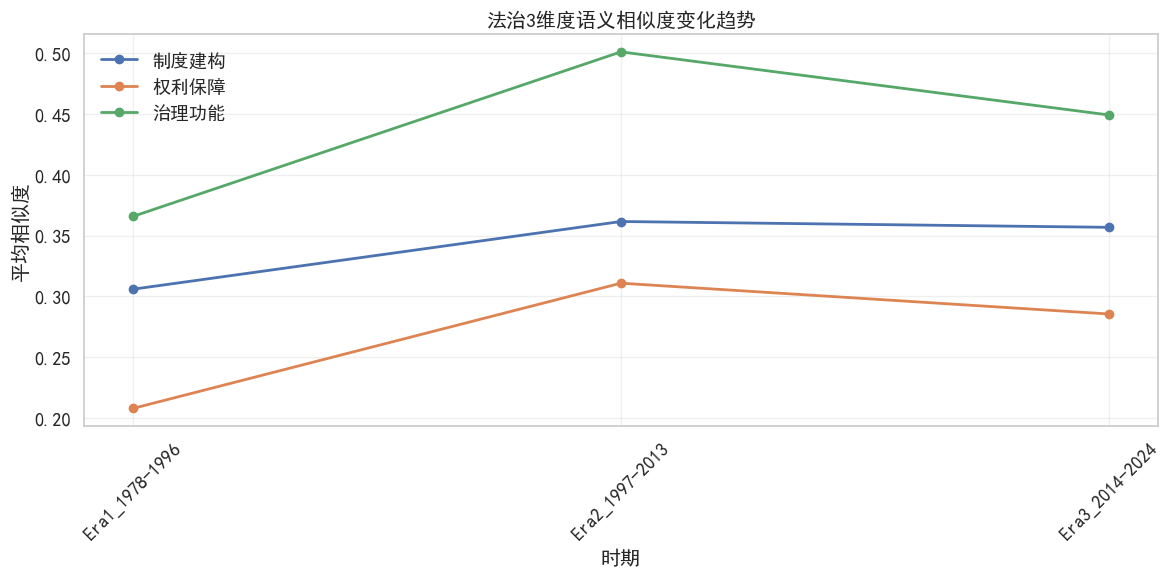

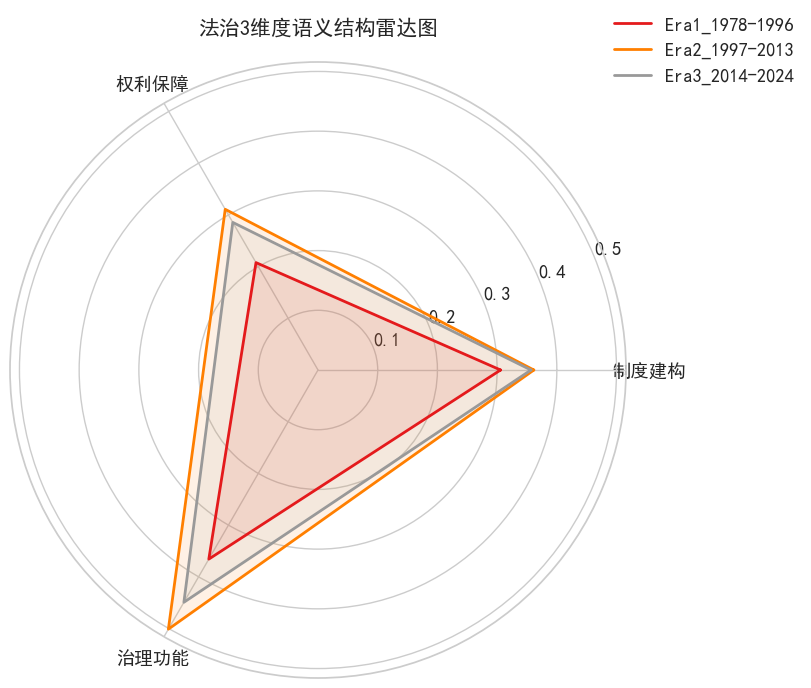

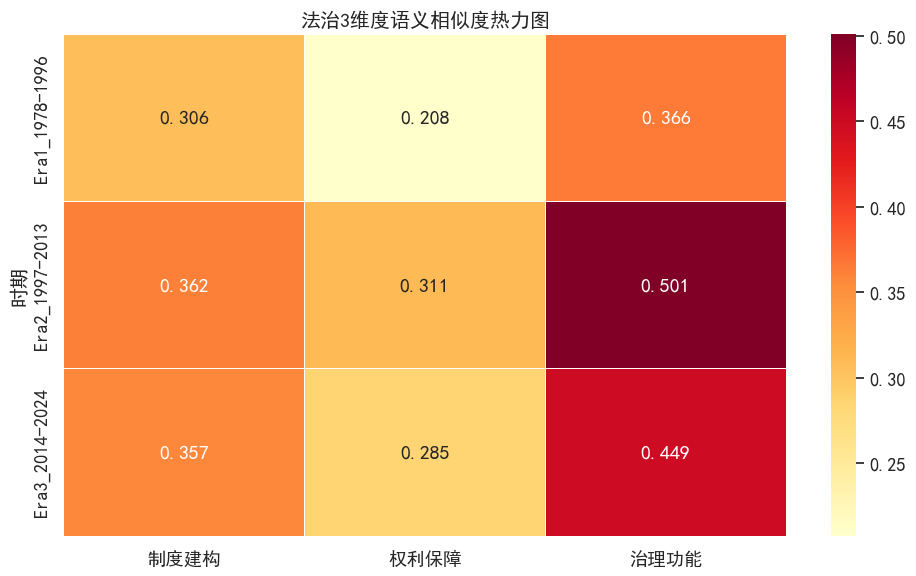


分析维度文件: /home/fangshikai/law-word-vector/topic_word/dimension_words_4d.txt
已加载维度词表:
  制度建构: 21 个词
  程序正义: 18 个词
  权利保障: 20 个词
  治理效能: 20 个词

4维度相似度矩阵:
               时期      制度建构      程序正义      权利保障      治理效能
0  Era1_1978-1996  0.309728  0.264290  0.207684  0.365729
1  Era2_1997-2013  0.357989  0.382325  0.310768  0.501166
2  Era3_2014-2024  0.360454  0.280954  0.285411  0.449224


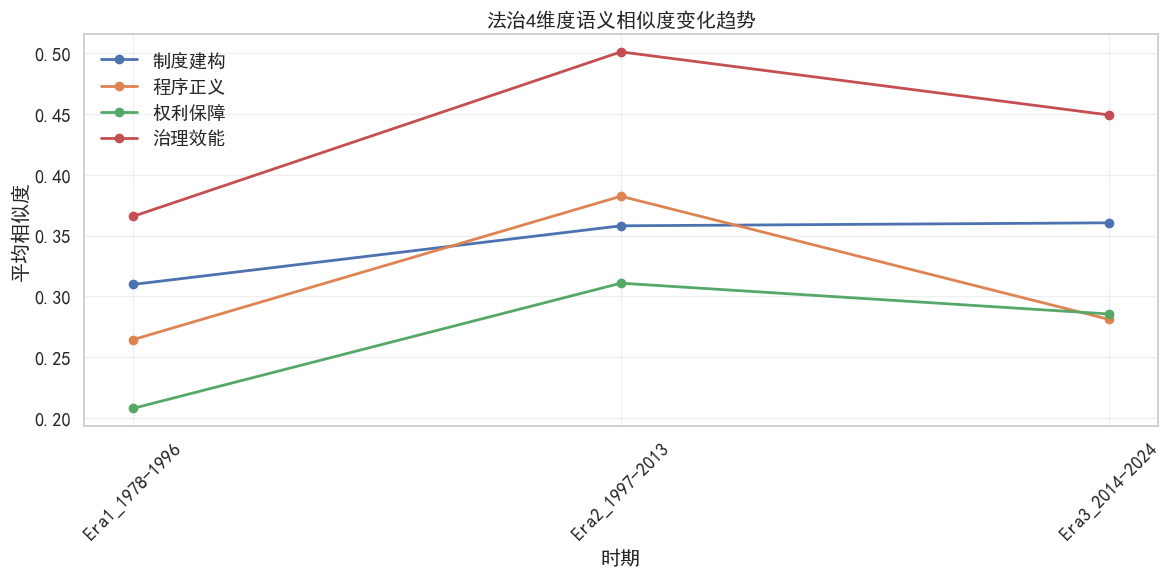

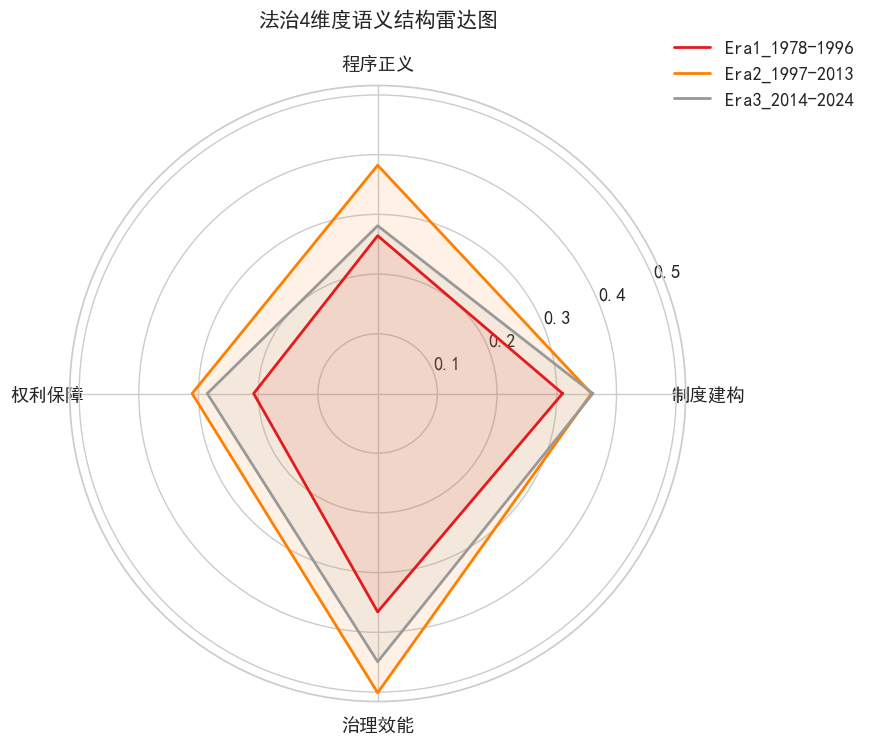

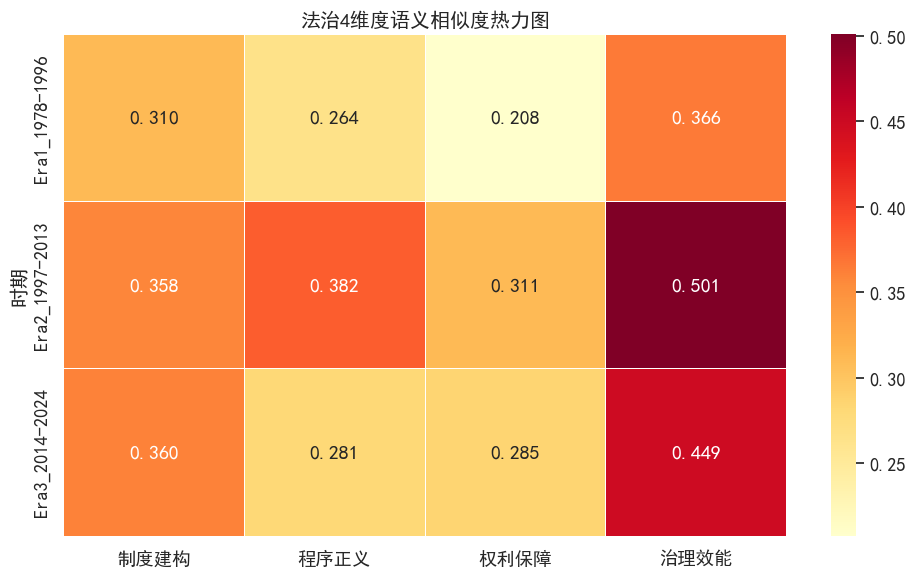


=== 扩展4D词表 ===


In [5]:
from dimension_analysis import DimensionAnalyzer



try:
    models = utils.load_models(MODELS_DIR)
    analyzer = DimensionAnalyzer(models)
except (ValueError, FileNotFoundError) as e:
    print(f"初始化分析器失败: {e}")


# 创建输出目录
output_dir = PROJECT_ROOT / "output" / "dimension_analysis"
output_dir.mkdir(parents=True, exist_ok=True)

topic_word_dir = PROJECT_ROOT / "topic_word"

# 2. 分析专家定义的维度词表
analyzer.run_analysis(topic_word_dir / "dimension_words_3d.txt")
analyzer.run_analysis(topic_word_dir / "dimension_words_4d.txt")

# 3. 扩展4D词表并保存
print("\n=== 扩展4D词表 ===")
dimension_words_4d = analyzer._load_dimension_words(topic_word_dir / "dimension_words_4d.txt")


=== 扩展4D词表 ===
使用所有 3 个模型的平均相似度进行词表扩展
候选词数量: 924



扩展后的词表统计:
制度建构: 50 个词 (原有 21 + 新增 29)
程序正义: 50 个词 (原有 18 + 新增 32)
权利保障: 41 个词 (原有 20 + 新增 21)
治理效能: 50 个词 (原有 20 + 新增 30)
已保存扩展词表到: /home/fangshikai/law-word-vector/output/dimension_analysis/expanded_dimension_words_4d.txt

=== 分析扩展后的4D词表 ===

分析维度文件: /home/fangshikai/law-word-vector/output/dimension_analysis/expanded_dimension_words_4d.txt
已加载维度词表:
  制度建构: 50 个词
  程序正义: 50 个词
  权利保障: 41 个词
  治理效能: 50 个词

4维度相似度矩阵:
               时期      制度建构      程序正义      权利保障      治理效能
0  Era1_1978-1996  0.325875  0.324687  0.252451  0.351241
1  Era2_1997-2013  0.363840  0.372861  0.347020  0.462903
2  Era3_2014-2024  0.356086  0.346215  0.298666  0.416634


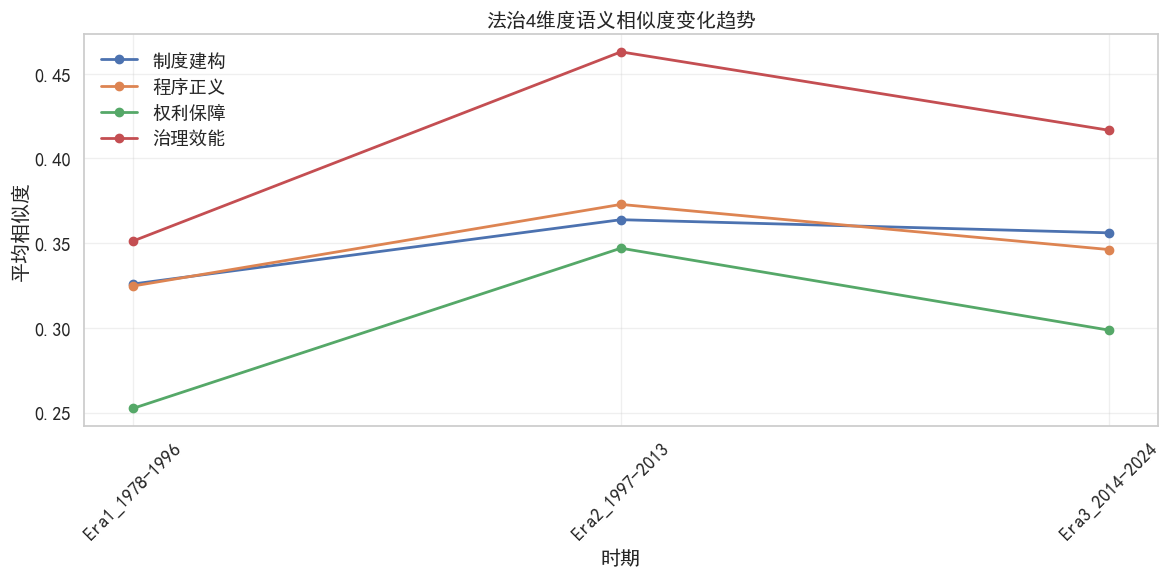

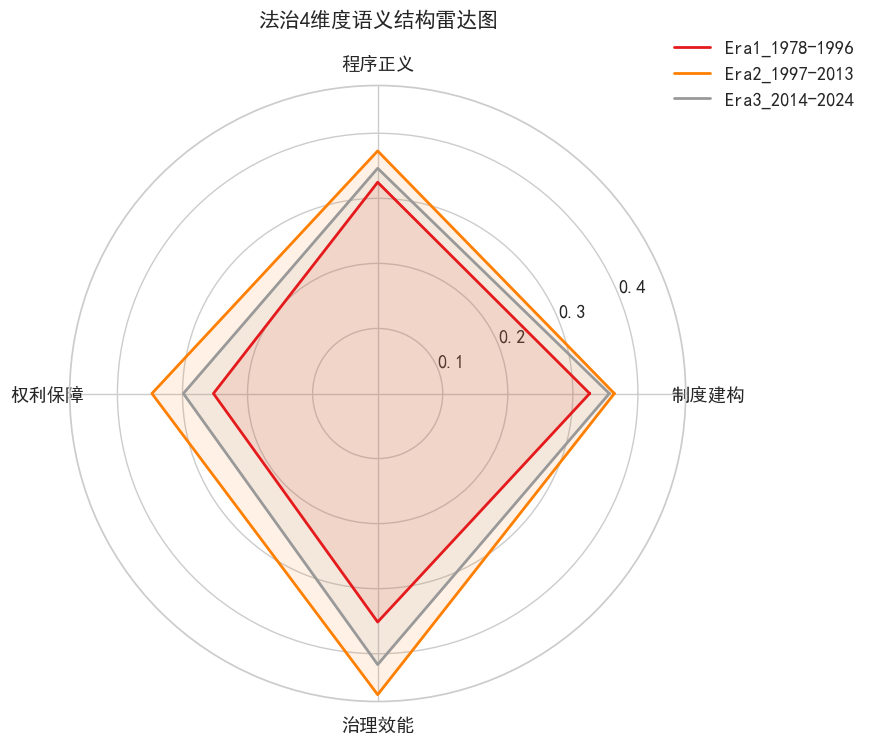

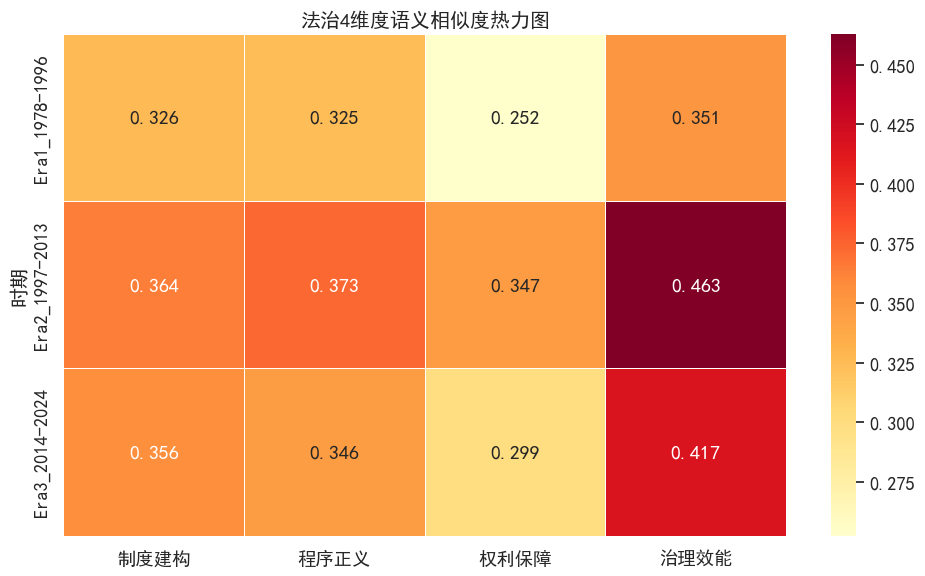


=== 分析完成 ===


In [6]:
# 3. 扩展4D词表并保存
print("\n=== 扩展4D词表 ===")
dimension_words_4d = analyzer._load_dimension_words(topic_word_dir / "dimension_words_4d.txt")
if dimension_words_4d:
    expanded_4d_words = analyzer.expand_dimension_words_by_similarity(
        dimension_words_4d, 
        target_word="法治",
        similarity_threshold=0.3,
        max_words_per_dim=50
    )
    
    # 保存扩展后的词表
    expanded_4d_output_path = output_dir / "expanded_dimension_words_4d.txt"
    analyzer.save_expanded_dimension_words(expanded_4d_words, expanded_4d_output_path)
    
    # (可选) 分析扩展后的词表
    print("\n=== 分析扩展后的4D词表 ===")
    analyzer.run_analysis(expanded_4d_output_path)

print("\n=== 分析完成 ===")